In [ ]:
git add .
git commit -m "Your commit message"
git push

In [1]:

# ## 0) Setup & Folders
# Keeps to the required structure:
# ds_<candidate_name>/
# ├── notebook_1.ipynb
# ├── notebook_2.ipynb   (optional)
# ├── csv_files/*.csv
# ├── outputs/*.png
# ├── ds_report.pdf
# └── README.md


!pip -q install gdown reportlab scipy

import os, math, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
warnings.filterwarnings("ignore")

# PDF
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.pdfgen import canvas

# Project folders
ROOT = Path(".")
PROJECT_ROOT = ROOT / "ds_kunal_aher"
CSV_DIR = PROJECT_ROOT / "csv_files"
OUT_DIR = PROJECT_ROOT / "outputs"
PROJECT_ROOT.mkdir(exist_ok=True)
CSV_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Project root:", PROJECT_ROOT)


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Project root: ds_kunal_aher


In [2]:

# ## 1) Download datasets
import gdown

FILE_IDS = {
    "trader": "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs",
    "sentiment": "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf",
}

def gdown_fetch(fid, out_path):
    url = f"https://drive.google.com/uc?id={fid}"
    print(f"Downloading → {out_path.name}")
    gdown.download(url, str(out_path), quiet=False)

paths = {}
for key, fid in FILE_IDS.items():
    out_path = CSV_DIR / f"{key}.csv"
    gdown_fetch(fid, out_path)
    paths[key] = out_path
paths

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /workspaces/Primetrade.ai_Task/ds_kunal_aher/csv_files/trader.csv
100%|██████████| 47.5M/47.5M [00:02<00:00, 16.8MB/s]


Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /workspaces/Primetrade.ai_Task/ds_kunal_aher/csv_files/sentiment.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 680kB/s]


{'trader': PosixPath('ds_kunal_aher/csv_files/trader.csv'),
 'sentiment': PosixPath('ds_kunal_aher/csv_files/sentiment.csv')}

In [3]:

# ## 2) Safe loading + column normalization


def smart_read(path: Path):
    for kwargs in [{}, {"engine":"python"}, {"sep":";"}, {"on_bad_lines":"skip"}]:
        try:
            return pd.read_csv(path, **kwargs)
        except Exception:
            pass
    try:
        return pd.read_excel(path)
    except Exception:
        pass
    try:
        return pd.read_json(path, lines=True)
    except Exception as e:
        raise RuntimeError(f"Could not read {path}: {e}")

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace("-", "_")
    )
    return df

df_trades_raw = smart_read(paths["trader"])
df_sent_raw   = smart_read(paths["sentiment"])

trades = normalize_cols(df_trades_raw)
sent   = normalize_cols(df_sent_raw)

print("Trades columns:", trades.columns.tolist())
print("Sentiment columns:", sent.columns.tolist())
display(trades.head())
display(sent.head())

Trades columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:

# ## 3) Parse timestamps & sentiment labels

def parse_trade_time(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # guess a time column
    time_candidates = [c for c in ["timestamp_ist","timestamp","time","created_at"] if c in df.columns]
    if not time_candidates:
        raise KeyError("No time column found. Expected one of: timestamp_ist, timestamp, time, created_at")
    tc = time_candidates[0]
    dt = pd.to_datetime(df[tc], errors="coerce", utc=True)
    if dt.isna().all():
        # epoch fallback
        try:
            dt = pd.to_datetime(df[tc].astype(float), unit="ms", utc=True, errors="coerce")
        except Exception:
            dt = pd.to_datetime(df[tc].astype(float), unit="s", utc=True, errors="coerce")
    df["timestamp"] = dt
    df["date"] = df["timestamp"].dt.date
    return df

def parse_sentiment_date(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    date_col = "date" if "date" in df.columns else [c for c in df.columns if "date" in c][0]
    cls_col  = "classification" if "classification" in df.columns else [c for c in df.columns if "class" in c][0]
    df["date"] = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.date
    df["classification"] = df[cls_col].astype(str).str.strip().str.title()  # Fear / Greed
    return df[["date","classification"]]

trades = parse_trade_time(trades)
sent   = parse_sentiment_date(sent)

display(trades[["timestamp","date"]].head())
display(sent.head())

,timestamp,date
0,2024-02-12 22:50:00+00:00,2024-02-12
1,2024-02-12 22:50:00+00:00,2024-02-12
2,2024-02-12 22:50:00+00:00,2024-02-12
3,2024-02-12 22:50:00+00:00,2024-02-12
4,2024-02-12 22:50:00+00:00,2024-02-12


,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [5]:

# ## 4) Feature engineering (robust column mapping)
# - Uses `size_usd` if present for **notional** (preferred).
# - Else uses `execution_price × size_tokens`.
# - Computes **pnl_per_usd**, **win flag**, and cleaned `side_std`.


t = trades.copy()

col_map = {
    "execution_price": ["execution_price","price","avg_price"],
    "size_tokens":     ["size_tokens","size","qty","quantity"],
    "size_usd":        ["size_usd","notional","trade_value_usd"],
    "side":            ["side","direction"],
    "closedpnl":       ["closed_pnl","closedpnl","pnl","realized_pnl","realizedpnl"],
    "leverage":        ["leverage","lev","start_position"],  # includes your proxy column
    "account":         ["account","trader","account_id"],
    "coin":            ["coin","symbol","asset","pair"],
}

def pick(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

price_c = pick(t, col_map["execution_price"])
sz_tok  = pick(t, col_map["size_tokens"])
sz_usd  = pick(t, col_map["size_usd"])
side_c  = pick(t, col_map["side"])
pnl_c   = pick(t, col_map["closedpnl"])
lev_c   = pick(t, col_map["leverage"])
acct_c  = pick(t, col_map["account"])
coin_c  = pick(t, col_map["coin"])

# Coerce numerics
if price_c: t["execution_price"] = pd.to_numeric(t[price_c], errors="coerce")
if sz_tok:  t["size_tokens"]     = pd.to_numeric(t[sz_tok],  errors="coerce")
if sz_usd:  t["size_usd"]        = pd.to_numeric(t[sz_usd],  errors="coerce")
if pnl_c:   t["closedpnl"]       = pd.to_numeric(t[pnl_c],   errors="coerce")
if lev_c:   t["leverage"]        = pd.to_numeric(t[lev_c],   errors="coerce")

# Notional rule: prefer size_usd; else price * tokens
if sz_usd and t["size_usd"].notna().any():
    t["notional"] = t["size_usd"].abs()
else:
    if price_c is None or sz_tok is None:
        raise KeyError("Missing columns for notional. Provide either size_usd or both execution_price and size_tokens.")
    t["notional"] = (t["execution_price"].abs() * t["size_tokens"].abs())

# Side
if side_c:
    t["side_std"] = (t[side_c].astype(str).str.strip().str.lower()
                     .map({"buy":"long","sell":"short"}).fillna(t[side_c].astype(str)))
else:
    t["side_std"] = np.nan

# Account/Coin stable names
if acct_c: t["account_std"] = t[acct_c].astype(str)
if coin_c: t["coin_std"]    = t[coin_c].astype(str)

# Normalized metrics
t["pnl_per_usd"] = np.where(t["notional"]>0, t["closedpnl"]/t["notional"], np.nan)
t["is_win"]      = (t["closedpnl"] > 0).astype(float)

# Merge sentiment
m = t.merge(sent, on="date", how="left").rename(columns={"classification":"sentiment"})
m["sentiment"] = m["sentiment"].fillna("Unknown")
m.to_csv(CSV_DIR / "trades_with_sentiment.csv", index=False)
display(m.head())

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,date,closedpnl,leverage,notional,side_std,account_std,coin_std,pnl_per_usd,is_win,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,2024-02-12,0.0,0.000000,7872.16,long,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,0.0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,2024-02-12,0.0,986.524596,127.68,long,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,0.0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,2024-02-12,0.0,1002.518996,1150.63,long,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,0.0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,2024-02-12,0.0,1146.558564,1142.04,long,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,0.0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,2024-02-12,0.0,1289.488521,69.75,long,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,0.0,Greed


In [6]:

# ## 5) Data quality checks (sentiment coverage & winsorization)

# Sentiment coverage
coverage = m["sentiment"].value_counts(dropna=False, normalize=True).rename("share").reset_index().rename(columns={"index":"sentiment"})
coverage.to_csv(CSV_DIR / "sentiment_coverage.csv", index=False)
print("Sentiment coverage:")
display(coverage)

# Winsorize heavy-tailed numeric columns to reduce outlier skew (1%/99%)
def winsorize(s, lower=0.01, upper=0.99):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.quantile(lower), s.quantile(upper)
    return s.clip(lo, hi)

for col in ["closedpnl","notional","pnl_per_usd","leverage"]:
    if col in m.columns:
        m[col+"_w"] = winsorize(m[col])

Sentiment coverage:


,sentiment,share
0,Unknown,0.830209
1,Fear,0.065660
2,Greed,0.053460
3,Extreme Greed,0.026612
4,Neutral,0.013048
5,Extreme Fear,0.011012


In [7]:

# ## 6) Aggregations (daily & by sentiment)

# %%
def win_rate(series):
    s = pd.to_numeric(series, errors="coerce")
    return float((s>0).mean()) if s.notna().any() else np.nan

group_key = ["date","sentiment"]

daily = (m.groupby(group_key).agg(
    trades       = ("notional","count"),
    notional_sum = ("notional","sum"),
    notional_med = ("notional","median"),
    lev_mean     = ("leverage","mean"),
    lev_med      = ("leverage","median"),
    pnl_sum      = ("closedpnl","sum"),
    pnl_mean     = ("closedpnl","mean"),
    pnl_winrate  = ("closedpnl", win_rate),
    r_mean       = ("pnl_per_usd","mean"),
    r_med        = ("pnl_per_usd","median"),
).reset_index())

by_sent = (m.groupby("sentiment").agg(
    trades       = ("notional","count"),
    notional_sum = ("notional","sum"),
    notional_avg = ("notional","mean"),
    lev_mean     = ("leverage","mean"),
    pnl_sum      = ("closedpnl","sum"),
    pnl_mean     = ("closedpnl","mean"),
    pnl_winrate  = ("closedpnl", win_rate),
    r_mean       = ("pnl_per_usd","mean"),
    r_med        = ("pnl_per_usd","median"),
).reset_index())

daily.to_csv(CSV_DIR / "daily_metrics.csv", index=False)
by_sent.to_csv(CSV_DIR / "summary_by_sentiment.csv", index=False)

display(daily.head())
display(by_sent)

,date,sentiment,trades,notional_sum,notional_med,lev_mean,lev_med,pnl_sum,pnl_mean,pnl_winrate,r_mean,r_med
0,2023-01-05,Fear,3,477.00,156.390,0.091933,0.0967,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-05-12,Neutral,9,50005.83,1935.950,2.513867,1.3614,0.000000,0.000000,0.000000,0.000000,0.000000
2,2024-01-01,Greed,18,264239.53,9216.095,414.773256,1.2602,-129.531460,-7.196192,0.055556,-0.001354,0.000000
3,2024-01-02,Greed,6,2008.18,252.115,18562.666667,22175.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2024-01-03,Greed,137,472974.70,1000.870,375587.745255,7377.0000,8244.241409,60.176945,0.934307,0.032566,0.034831


,sentiment,trades,notional_sum,notional_avg,lev_mean,pnl_sum,pnl_mean,pnl_winrate,r_mean,r_med
0,Extreme Fear,2326,9.580240e+06,4118.761840,21902.797505,4.399937e+03,1.891632,0.292777,0.003188,0.000000
1,Extreme Greed,5621,1.822376e+07,3242.085086,24593.241160,1.156894e+06,205.816345,0.553282,0.134938,0.009622
2,Fear,13869,7.967439e+07,5744.782685,8146.358518,1.779226e+06,128.287950,0.381787,0.029822,0.000000
3,Greed,11292,5.704582e+07,5051.878829,37276.787811,6.096325e+05,53.988003,0.435707,0.030462,0.000000
4,Neutral,2756,1.193955e+07,4332.202906,89199.587406,7.465674e+04,27.088803,0.494920,0.023814,0.000000
5,Unknown,175360,1.014724e+09,5786.517359,-41596.124415,6.672150e+06,38.048303,0.407727,0.013818,0.000000


In [8]:

# ## 7) Deep dives (coin/account/time cohorts)

# By coin
if "coin_std" in m.columns:
    by_coin = (m.groupby(["sentiment","coin_std"]).agg(
        trades=("notional","count"),
        notional_sum=("notional","sum"),
        r_mean=("pnl_per_usd","mean"),
        pnl_mean=("closedpnl","mean"),
        winrate=("closedpnl", win_rate),
    ).reset_index())
    by_coin.to_csv(CSV_DIR / "by_coin.csv", index=False)

# By account
if "account_std" in m.columns:
    by_acct = (m.groupby(["sentiment","account_std"]).agg(
        trades=("notional","count"),
        notional_sum=("notional","sum"),
        r_mean=("pnl_per_usd","mean"),
        pnl_mean=("closedpnl","mean"),
        winrate=("closedpnl", win_rate),
    ).reset_index())
    by_acct.to_csv(CSV_DIR / "by_account.csv", index=False)

# Monthly time cohorts
m["month"] = pd.to_datetime(m["timestamp"]).dt.to_period("M").dt.to_timestamp()
by_month = (m.groupby(["sentiment","month"]).agg(
    trades=("notional","count"),
    notional_sum=("notional","sum"),
    r_mean=("pnl_per_usd","mean"),
    pnl_mean=("closedpnl","mean"),
    winrate=("closedpnl", win_rate),
).reset_index())
by_month.to_csv(CSV_DIR / "by_month.csv", index=False)


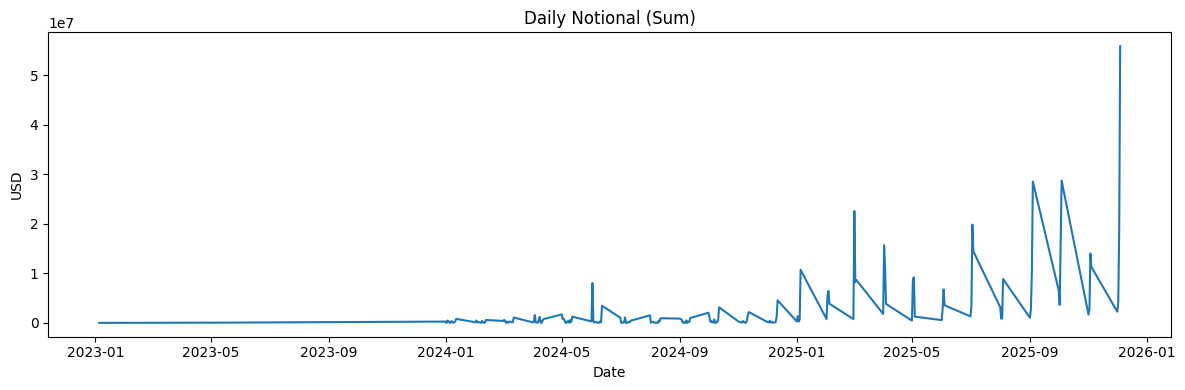

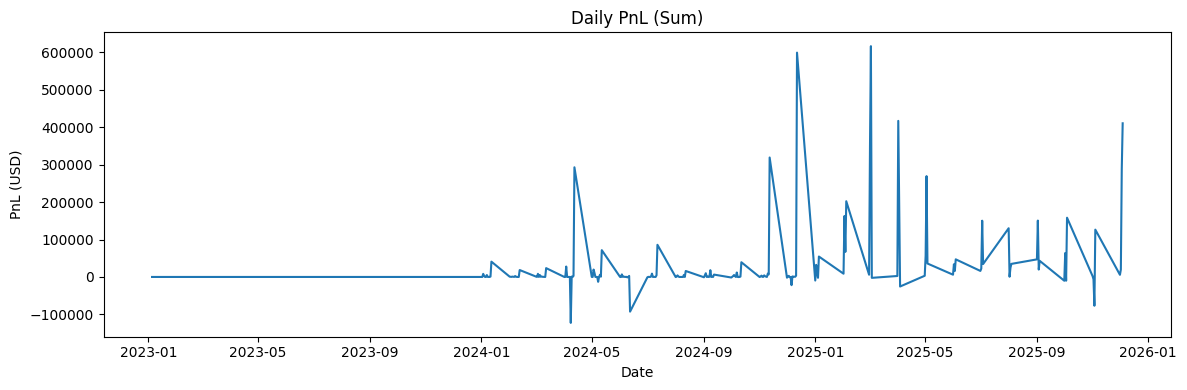

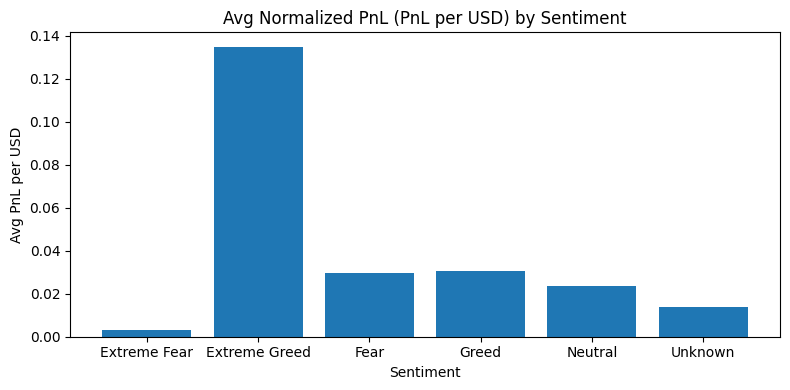

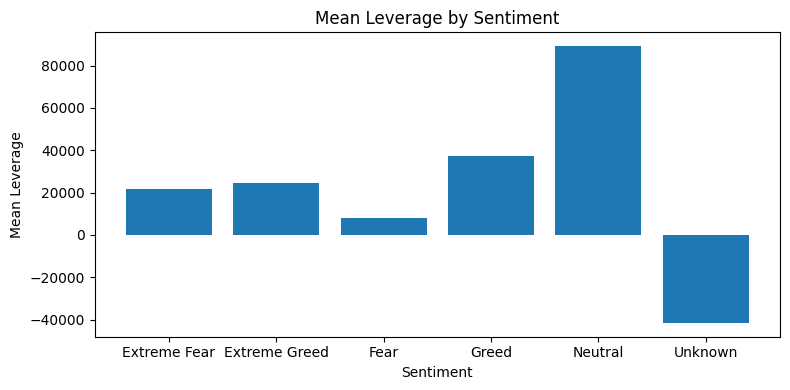

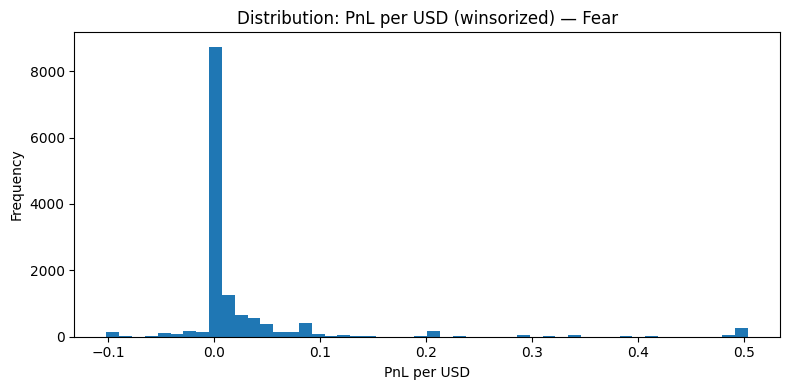

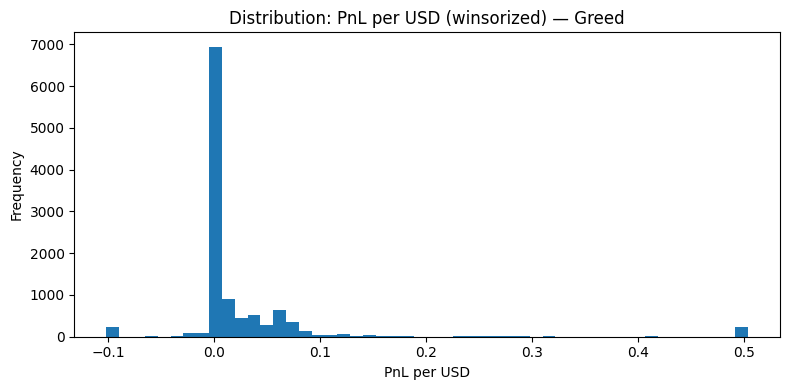

Saved figures to: ds_kunal_aher/outputs


In [9]:

# ## 8) Visuals (saved to `outputs/`)

plt.figure(figsize=(12,4))
dts = pd.to_datetime(daily["date"])
plt.plot(dts, daily["notional_sum"])
plt.title("Daily Notional (Sum)")
plt.xlabel("Date"); plt.ylabel("USD")
plt.tight_layout(); plt.savefig(OUT_DIR/"timeseries_notional_sum.png", dpi=150); plt.show()

plt.figure(figsize=(12,4))
plt.plot(dts, daily["pnl_sum"])
plt.title("Daily PnL (Sum)")
plt.xlabel("Date"); plt.ylabel("PnL (USD)")
plt.tight_layout(); plt.savefig(OUT_DIR/"timeseries_pnl_sum.png", dpi=150); plt.show()

plt.figure(figsize=(8,4))
plt.bar(by_sent["sentiment"].astype(str), by_sent["r_mean"])
plt.title("Avg Normalized PnL (PnL per USD) by Sentiment")
plt.xlabel("Sentiment"); plt.ylabel("Avg PnL per USD")
plt.tight_layout(); plt.savefig(OUT_DIR/"bar_avg_r_by_sentiment.png", dpi=150); plt.show()

plt.figure(figsize=(8,4))
plt.bar(by_sent["sentiment"].astype(str), by_sent["lev_mean"])
plt.title("Mean Leverage by Sentiment")
plt.xlabel("Sentiment"); plt.ylabel("Mean Leverage")
plt.tight_layout(); plt.savefig(OUT_DIR/"bar_leverage_by_sentiment.png", dpi=150); plt.show()

# Distribution of pnl_per_usd (winsorized) by sentiment
for snt in ["Fear","Greed"]:
    ser = m.loc[m["sentiment"]==snt, "pnl_per_usd_w"].dropna()
    if ser.empty: continue
    plt.figure(figsize=(8,4))
    plt.hist(ser, bins=50)
    plt.title(f"Distribution: PnL per USD (winsorized) — {snt}")
    plt.xlabel("PnL per USD"); plt.ylabel("Frequency")
    plt.tight_layout(); plt.savefig(OUT_DIR/f"hist_r_w_{snt.lower()}.png", dpi=150); plt.show()

print("Saved figures to:", OUT_DIR)


In [10]:


# ## 9) Statistical tests: Fear vs Greed
# - Mann–Whitney U (non-parametric)
# - Cliff’s delta (effect size)
# - Tail risk (5th percentile PnL per USD)

# %%
def subset_sent(col):
    a = pd.to_numeric(m.loc[m["sentiment"]=="Fear",  col], errors="coerce").dropna()
    b = pd.to_numeric(m.loc[m["sentiment"]=="Greed", col], errors="coerce").dropna()
    return a, b

def cliffs_delta(x, y):
    # robust effect size: delta in [-1,1]
    nx, ny = len(x), len(y)
    if nx==0 or ny==0: return np.nan
    from itertools import product
    gt = sum(1 for a,b in product(x,y) if a>b)
    lt = sum(1 for a,b in product(x,y) if a<b)
    return (gt - lt) / (nx*ny)

tests = {}
for col in ["leverage","closedpnl","notional","pnl_per_usd","pnl_per_usd_w"]:
    a, b = subset_sent(col)
    if len(a) > 10 and len(b) > 10:
        u, p = stats.mannwhitneyu(a, b, alternative="two-sided")
        delta = cliffs_delta(a, b)
        tests[col] = {
            "test":"mannwhitneyu",
            "U": float(u),
            "p_value": float(p),
            "cliffs_delta": float(delta),
            "fear_median": float(np.median(a)),
            "greed_median": float(np.median(b))
        }

# Tail risk
def pct(x, q):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(np.percentile(x, q)) if len(x) else np.nan

tail = {
    "r_p05_fear":  pct(m.loc[m["sentiment"]=="Fear",  "pnl_per_usd"], 5),
    "r_p05_greed": pct(m.loc[m["sentiment"]=="Greed", "pnl_per_usd"], 5),
}
pd.DataFrame([tests]).to_csv(CSV_DIR/"tests_summary.json.csv", index=False)
json.dump({"tests":tests, "tail":tail}, open(CSV_DIR/"tests_summary.json","w"))

tests, tail

({'leverage': {'test': 'mannwhitneyu',
   'U': 75105706.5,
   'p_value': 2.3790380083073973e-08,
   'cliffs_delta': -0.04084915486330304,
   'fear_median': 11.36776,
   'greed_median': 6.633095000000001},
  'closedpnl': {'test': 'mannwhitneyu',
   'U': 75315632.5,
   'p_value': 1.7789822003855918e-08,
   'cliffs_delta': -0.038168257369633016,
   'fear_median': 0.0,
   'greed_median': 0.0},
  'notional': {'test': 'mannwhitneyu',
   'U': 79147074.0,
   'p_value': 0.1414101125906802,
   'cliffs_delta': 0.010761850928020955,
   'fear_median': 703.88,
   'greed_median': 675.0799999999999},
  'pnl_per_usd': {'test': 'mannwhitneyu',
   'U': 75029229.0,
   'p_value': 1.6375941222548899e-09,
   'cliffs_delta': -0.04087963707678355,
   'fear_median': 0.0,
   'greed_median': 0.0},
  'pnl_per_usd_w': {'test': 'mannwhitneyu',
   'U': 75048082.5,
   'p_value': 2.0388675817851765e-09,
   'cliffs_delta': -0.04063862732627188,
   'fear_median': 0.0,
   'greed_median': 0.0}},
 {'r_p05_fear': -0.00495111

In [11]:

# ## 10) Build `ds_report.pdf`

# %%
pdf_path = PROJECT_ROOT / "ds_report.pdf"
c = canvas.Canvas(str(pdf_path), pagesize=A4)
W, H = A4; M = 3*cm

def draw_title(txt, y, size=18):
    c.setFont("Helvetica-Bold", size); c.drawString(M, y, txt); return y - 1.2*cm
def draw_text(txt, y, size=11):
    c.setFont("Helvetica", size)
    for line in txt.split("\n"):
        c.drawString(M, y, line); y -= 0.6*cm
    return y

y = H - M
y = draw_title("Web3 Trading — DS Report (Auto Summary)", y)
y = draw_text("Objective: Analyze how trading behavior aligns/diverges from Fear vs Greed.", y)

# Coverage
y = draw_title("Data Quality — Sentiment Coverage", y, size=14)
try:
    cov_txt = ", ".join([f"{r.sentiment}: {r.share:.1%}" for _,r in coverage.iterrows()])
    y = draw_text(f"Share of trades by sentiment label (including 'Unknown'): {cov_txt}", y)
except Exception as e:
    y = draw_text(f"(Coverage summary unavailable: {e})", y)

# By-sentiment KPIs
y = draw_title("Key Metrics by Sentiment", y, size=14)
try:
    for _,row in by_sent.iterrows():
        s = (f"{row['sentiment']} | Trades: {int(row['trades'])} | Notional Sum: {row['notional_sum']:.2f} | "
             f"Lev Mean: {row['lev_mean']:.2f} | PnL Sum: {row['pnl_sum']:.2f} | "
             f"Win Rate: {row['pnl_winrate']:.2%} | Avg PnL/USD: {row['r_mean']:.5f}")
        y = draw_text(s, y)
except Exception as e:
    y = draw_text(f"(Could not render by-sentiment summary: {e})", y)

# Tests
y = draw_title("Statistical Tests (Fear vs Greed)", y, size=14)
if not tests:
    y = draw_text("Insufficient data for robust tests (need >10 samples per group).", y)
else:
    for k,v in tests.items():
        y = draw_text(f"{k}: U={v['U']:.1f}, p={v['p_value']:.4f}, Cliff's δ={v['cliffs_delta']:.3f}, "
                      f"med(Fear)={v['fear_median']:.4f}, med(Greed)={v['greed_median']:.4f}", y)
y = draw_text(f"Tail risk (5th pct PnL/USD): Fear={tail['r_p05_fear']:.5f} | Greed={tail['r_p05_greed']:.5f}", y)

# Add charts
for img in [
    OUT_DIR/"timeseries_notional_sum.png",
    OUT_DIR/"timeseries_pnl_sum.png",
    OUT_DIR/"bar_avg_r_by_sentiment.png",
    OUT_DIR/"bar_leverage_by_sentiment.png",
    OUT_DIR/"hist_r_w_fear.png",
    OUT_DIR/"hist_r_w_greed.png",
]:
    if y < 8*cm: c.showPage(); y = H - M
    if img.exists():
        c.drawImage(str(img), M, y-6*cm, width=W-2*M, height=6*cm, preserveAspectRatio=True)
        y -= 6.5*cm

c.showPage(); c.save()
print("Wrote report to:", pdf_path)

Wrote report to: ds_kunal_aher/ds_report.pdf


In [12]:

# ## 11) Artifact listing (for graders)

# %%
print("CSV files:")
for p in sorted(CSV_DIR.glob("*.csv")): print(" -", p.name)
print("\nImages:")
for p in sorted(OUT_DIR.glob("*.png")): print(" -", p.name)
print("\nReport:")
print(" -", pdf_path.name)


CSV files:
 - by_account.csv
 - by_coin.csv
 - by_month.csv
 - daily_metrics.csv
 - sentiment.csv
 - sentiment_coverage.csv
 - summary_by_sentiment.csv
 - tests_summary.json.csv
 - trader.csv
 - trades_with_sentiment.csv

Images:
 - bar_avg_r_by_sentiment.png
 - bar_leverage_by_sentiment.png
 - hist_r_w_fear.png
 - hist_r_w_greed.png
 - timeseries_notional_sum.png
 - timeseries_pnl_sum.png

Report:
 - ds_report.pdf
